In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing

from scipy.stats import skew
%matplotlib inline

In [2]:
# 1. Import Dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

print(f'Train shape : {train.shape}')

Train shape : (1460, 81)


Removed outliers, train shape : (1454, 81)


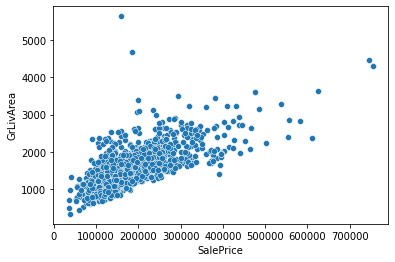

In [3]:
# 2. Outliers

#Remove cheap and expensive house price

sns.scatterplot(data=train, x='SalePrice', y='GrLivArea')

#remove >600k SalePrice and >4000 GrLivArea
train = train[train.SalePrice<600000]

train = train[train.GrLivArea<4000]

print(f'Removed outliers, train shape : {train.shape}')

In [11]:
numerical_features = train[f for f in train.columns if train[f].dtype != 'object']

SyntaxError: invalid syntax (2170786879.py, line 1)

In [23]:
a = [f for f in train.columns if train[f].dtype != 'object']
print(a)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [ ]:
# 3. Study dataset
corr = train.corr()
sns.heatmap(corr)

In [ ]:
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr.SalePrice.head(20)

In [ ]:
selected_col = corr.SalePrice[corr.SalePrice > 0.4]
print(selected_col)

In [ ]:
train[selected_col.index].info()

In [ ]:
train = train[selected_col.index]
train.head()

In [ ]:
null_sum = train.isnull().sum()
null_sum[null_sum > 0].plot.bar()

In [ ]:
null_columns = list(pd.DataFrame(null_sum[null_sum > 0]).index)

for c in null_columns:
    if train[c].dtype == 'object':
        train[c] = train[[c]].replace(np.NAN, train[c].mode()[0])
    else:
        train[c] = train[c].replace(np.NAN, train[c].mean())
        
print(train.isnull().sum()[train.isnull().sum() > 0])

In [ ]:
#Creating polynomials feature
for c in train.drop(columns=['SalePrice']):
    train[c + '_s2'] = train[c] ** 2
    train[c + '_s3'] = train[c] ** 3
    train[c + '_sqrt'] = np.sqrt(train[c])

In [ ]:
len(train.columns)

In [ ]:
# 5 Check Skewness and Log Transform 

skewness = train.apply(lambda x: skew(x))

skewness = skewness[abs(skewness) > 0.5]
print(skewness)

In [ ]:
print(str(skewness.shape[0]) + " skewed numerical features to log transform")

In [ ]:
skewed_features = skewness.index
train[skewed_features] = np.log1p(train[skewed_features])

In [ ]:
y = train.SalePrice
train=train.drop(columns=['SalePrice'])

train.head()

# 6. Ridge model 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state=0)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

In [ ]:
X_train.head()

In [ ]:
# Standardize numerical features
stdSc = StandardScaler()
X_train = pd.DataFrame(stdSc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(stdSc.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
# X_train = X_train.drop(columns=['SalePrice'])

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [ ]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

In [ ]:
alpha_list = list(alpha*np.arange(0.6,1.4,0.05))

In [ ]:
alpha_list = [ '%.4f' % elem for elem in alpha_list ]
print(alpha_list)

In [ ]:
ridge = RidgeCV(alphas = alpha_list, 
                cv = 10)

In [ ]:
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

In [ ]:
alpha_list = list(0.006*np.arange(0.05,0.95,0.05))
alpha_list = [ '%.4f' % elem for elem in alpha_list ]
print(alpha_list)

In [ ]:
ridge = RidgeCV(alphas = alpha_list, 
                cv = 10)

In [ ]:
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

In [ ]:
print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
pp.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
pp.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
pp.title("Linear regression with Ridge regularization")
pp.xlabel("Predicted values")
pp.ylabel("Residuals")
pp.legend(loc = "upper left")
pp.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
pp.show()

# Plot predictions
pp.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
pp.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
pp.title("Linear regression with Ridge regularization")
pp.xlabel("Predicted values")
pp.ylabel("Real values")
pp.legend(loc = "upper left")
pp.plot([10.5, 13.5], [10.5, 13.5], c = "red")
pp.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
pp.title("Coefficients in the Ridge Model")
pp.show()

# 6. Test set prediction 

In [ ]:
df_test = pd.read_csv('test.csv')
df_test.head()

In [ ]:
print(f'Test dataset shape: {df_test.shape}')

In [ ]:
selected_col.index

In [ ]:
df_test = pd.DataFrame(data=df_test, columns=selected_col.index[1:])
df_test.head()

In [ ]:
null_sum = df_test.isnull().sum()
null_sum[null_sum > 0].plot.bar()

In [ ]:
null_columns = list(pd.DataFrame(null_sum[null_sum > 0]).index)

for c in null_columns:
    if df_test[c].dtype == 'object':
        df_test[c] = df_test[[c]].replace(np.NAN, df_test[c].mode()[0])
    else:
        df_test[c] = df_test[c].replace(np.NAN, df_test[c].mean())
        
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])

In [ ]:
df_test.columns

In [ ]:
for c in df_test.columns:
    df_test[c + '_s2'] = df_test[c] ** 2
    df_test[c + '_s3'] = df_test[c] ** 3
    df_test[c + '_sqrt'] = np.sqrt(df_test[c])

In [ ]:
print(df_test.columns)

In [ ]:
skewed_features = skewness.index
skewed_features = skewed_features[1:]
print(f'Features to be skewed: {skewed_features}')

In [ ]:
df_test[skewed_features] = np.log1p(df_test[skewed_features])

In [ ]:
df_test.head()

In [ ]:
df_test = pd.DataFrame(stdSc.fit_transform(df_test), columns=df_test.columns, index=df_test.index)

In [ ]:
df_test.head()

In [ ]:
test_pred = ridge.predict(df_test)
print(test_pred)

In [ ]:
test_pred = np.expm1(test_pred)
print(test_pred)

In [ ]:
submission = pd.concat([pd.read_csv('test.csv').Id, pd.DataFrame(test_pred, columns=['SalePrice'])], axis=1)
submission.head()

In [ ]:
submission.to_csv('Prediction5.csv',index=False)

In [ ]:
# pd.read_csv('Prediction2.csv').head()